In [1]:
!pip install torch numpy shap pillow torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

import matplotlib.pyplot as plt
from PIL import Image
import random, os
import numpy as np
import shap

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#train and test data directory
data_dir = "/content/drive/MyDrive/data/train"
test_data_dir = "/content/drive/MyDrive/data/test"

In [4]:
### Redefine the 'ImageFolder' class so it won't load the corrupted files

class ImageFolderEX(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        try:
            sample = self.loader(path)
        except:
            return None
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target

In [5]:
transform = transforms.Compose([transforms.Resize((256,256)),
                                transforms.ToTensor()])

#load the train and test data
dataset = ImageFolderEX(data_dir, transform = transform)
test_ds = ImageFolderEX(test_data_dir, transform = transform)

print('dataset samples:', len(dataset))
print('test samples:', len(test_ds))
print("Classes are:", dataset.classes)

img, label = dataset[0]
print(f'Example: first sample size: {img.shape}, and label: {label}')

dataset samples: 1924
test samples: 1932
Classes are: ['infected', 'notinfected']
Example: first sample size: torch.Size([3, 256, 256]), and label: 0


In [6]:
batch_size = 128
val_size = 400
train_size = len(dataset) - val_size

train_data, val_data = random_split(dataset, [train_size, val_size])

print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

Length of Train Data : 1524
Length of Validation Data : 400


In [7]:
#load the train and validation into batches
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

train_dl = DataLoader(train_data, batch_size, shuffle = True, collate_fn=collate_fn, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, collate_fn=collate_fn, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


torch.Size([128, 3, 256, 256]) torch.Size([128])


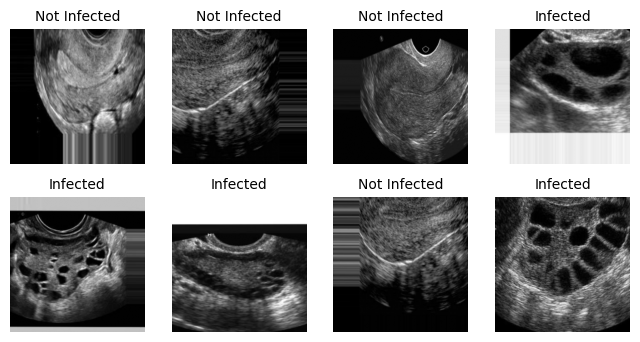

In [8]:
# Get one batch from dataset
images, labels = next(iter(train_dl))
print(images.shape , labels.shape)

plt.figure(figsize=(8,4))

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i,0], cmap=plt.cm.gray)
    if labels[i]==0:
        plt.title('Infected', fontsize=10)
    else:
        plt.title('Not Infected', fontsize=10)
    plt.axis("off")

Define the CNN model¶
I used the model from here: https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48, and the same architecture as Model2 in: https://www.kaggle.com/code/aykorde/fightos-cnn-models#Model-2

In [9]:
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):

    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):

        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [11]:
class Classifier(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(3, 12, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(3,3),

            nn.Conv2d(12, 15, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(3,3),

            nn.Conv2d(15, 10, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(3,3),

            nn.Flatten(),
            nn.Linear(810, 2),
        )

    def forward(self, xb):
        return self.network(xb)

In [13]:
model = Classifier().to(device)

for name, params in model.named_parameters():
    print('layer name: {}, \t params shape: {}'.format(name, params.shape))

layer name: network.0.weight, 	 params shape: torch.Size([12, 3, 3, 3])
layer name: network.0.bias, 	 params shape: torch.Size([12])
layer name: network.3.weight, 	 params shape: torch.Size([15, 12, 3, 3])
layer name: network.3.bias, 	 params shape: torch.Size([15])
layer name: network.6.weight, 	 params shape: torch.Size([10, 15, 3, 3])
layer name: network.6.bias, 	 params shape: torch.Size([10])
layer name: network.10.weight, 	 params shape: torch.Size([2, 810])
layer name: network.10.bias, 	 params shape: torch.Size([2])


In [14]:
num_epochs = 20 # plz set to 20
opt_func = torch.optim.Adam
lr = 0.001

#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.6238, val_loss: 0.5168, val_acc: 0.8194
Epoch [1], train_loss: 0.4244, val_loss: 0.3145, val_acc: 0.8722
Epoch [2], train_loss: 0.3211, val_loss: 0.2786, val_acc: 0.8800
Epoch [3], train_loss: 0.2744, val_loss: 0.1992, val_acc: 0.9297
Epoch [4], train_loss: 0.1863, val_loss: 0.1453, val_acc: 0.9375
Epoch [5], train_loss: 0.1201, val_loss: 0.0840, val_acc: 0.9759
Epoch [6], train_loss: 0.0686, val_loss: 0.0600, val_acc: 0.9887
Epoch [7], train_loss: 0.0437, val_loss: 0.0250, val_acc: 0.9946
Epoch [8], train_loss: 0.0263, val_loss: 0.0257, val_acc: 0.9907
Epoch [9], train_loss: 0.0273, val_loss: 0.0151, val_acc: 0.9961
Epoch [10], train_loss: 0.0138, val_loss: 0.0087, val_acc: 0.9980
Epoch [11], train_loss: 0.0081, val_loss: 0.0089, val_acc: 0.9980
Epoch [12], train_loss: 0.0054, val_loss: 0.0065, val_acc: 0.9980
Epoch [13], train_loss: 0.0064, val_loss: 0.0068, val_acc: 0.9980
Epoch [14], train_loss: 0.0050, val_loss: 0.0046, val_acc: 0.9980
Epoch [15], train_lo

In [15]:
#save the model
torch.save(model.state_dict(), 'PCOS_detection_{}_epochs_val_acc_{}.pth'.format(num_epochs, history[-1]['val_acc']))

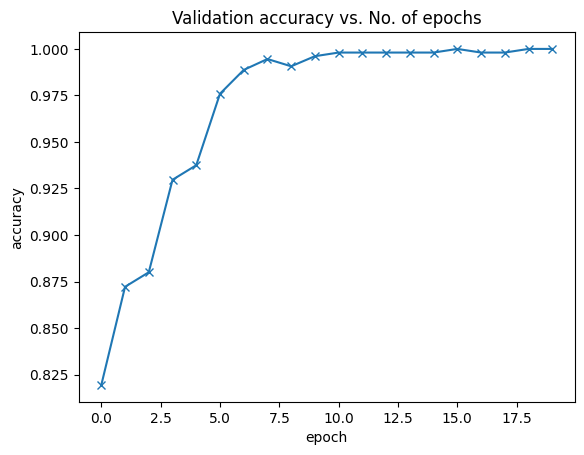

In [16]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Validation accuracy vs. No. of epochs');

plot_accuracies(history)

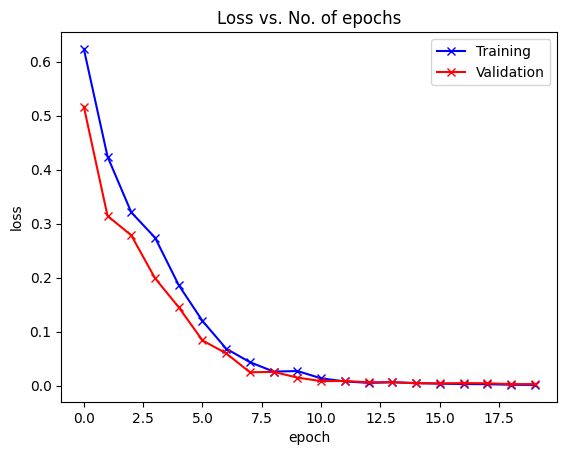

In [17]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [18]:
result = evaluate(model, test_dl)
result

{'val_loss': 0.0019146095728501678, 'val_acc': 1.0}

In [19]:
def predict_img_class(img,model):
    """ Predict the class of image and Return Predicted Class"""
    img = img.unsqueeze(0).to(device)
    prediction =  model(img)
    _, preds = torch.max(prediction, dim = 1)
    return dataset.classes[preds[0].item()]

Predicted Class: infected


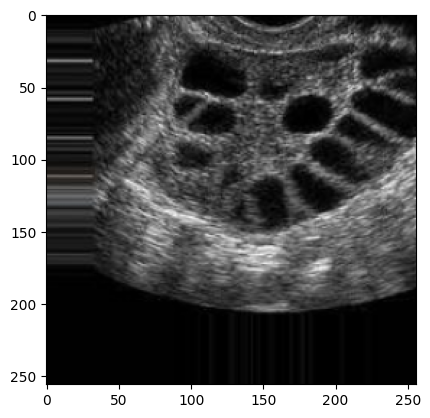

In [21]:
test_img = random.choice(os.listdir('/content/drive/MyDrive/data/test/infected'))
img = Image.open(f'/content/drive/MyDrive/data/test/infected/{test_img}')
img = transform(img)
plt.imshow(img.permute(1,2,0))

pred = predict_img_class(img,model)
print(f"Predicted Class: {pred}")

Explain the model using SHAP Explainer

In [22]:
# Use CPU for SHAP explainer
shap_device = torch.device('cpu')
model = model.to(shap_device)

In [23]:
#Load a batch from train data for background
background, labels = next(iter(train_dl))
background = background.to(shap_device)

#Load a batch from test data
test_images, test_labels = next(iter(test_dl))

print('background images:', background.shape)
print('background labels:', labels.shape)
print('test images:', test_images.shape)

background images: torch.Size([128, 3, 256, 256])
background labels: torch.Size([128])
test images: torch.Size([8, 3, 256, 256])


In [24]:
#Create the SHAP explainer and get shap values
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(test_images)

print('Shap values:', len(shap_values), shap_values[0].shape)

/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: Flatten
  warnings.warn(f"unrecognized nn.Module: {module_type}")


Shap values: 8 (3, 256, 256, 2)


In [25]:
# Convert to numpy and reshape for plotting
shap_numpy = list(np.array(shap_values).transpose(0,1,3,4,2))
test_numpy = np.array(test_images).transpose(0,2,3,1)

print('Shap values, numpy:', len(shap_numpy), shap_numpy[0].shape)
print('test images, numpy:', test_numpy.shape)

Shap values, numpy: 8 (3, 256, 2, 256)
test images, numpy: (8, 256, 256, 3)


In [26]:
test_list_labels = list(np.array(test_labels))
GT_labels = [dataset.classes[test_list_labels[i].item()] for i in range(len(test_list_labels))]
print(GT_labels)

['infected', 'infected', 'notinfected', 'infected', 'infected', 'notinfected', 'infected', 'infected']


In [27]:
print("shap_numpy[0] shape:", shap_numpy[0].shape)
print("test_numpy shape:", test_numpy.shape)
print("GT_labels length:", len(GT_labels))

shap_numpy[0] shape: (3, 256, 2, 256)
test_numpy shape: (8, 256, 256, 3)
GT_labels length: 8


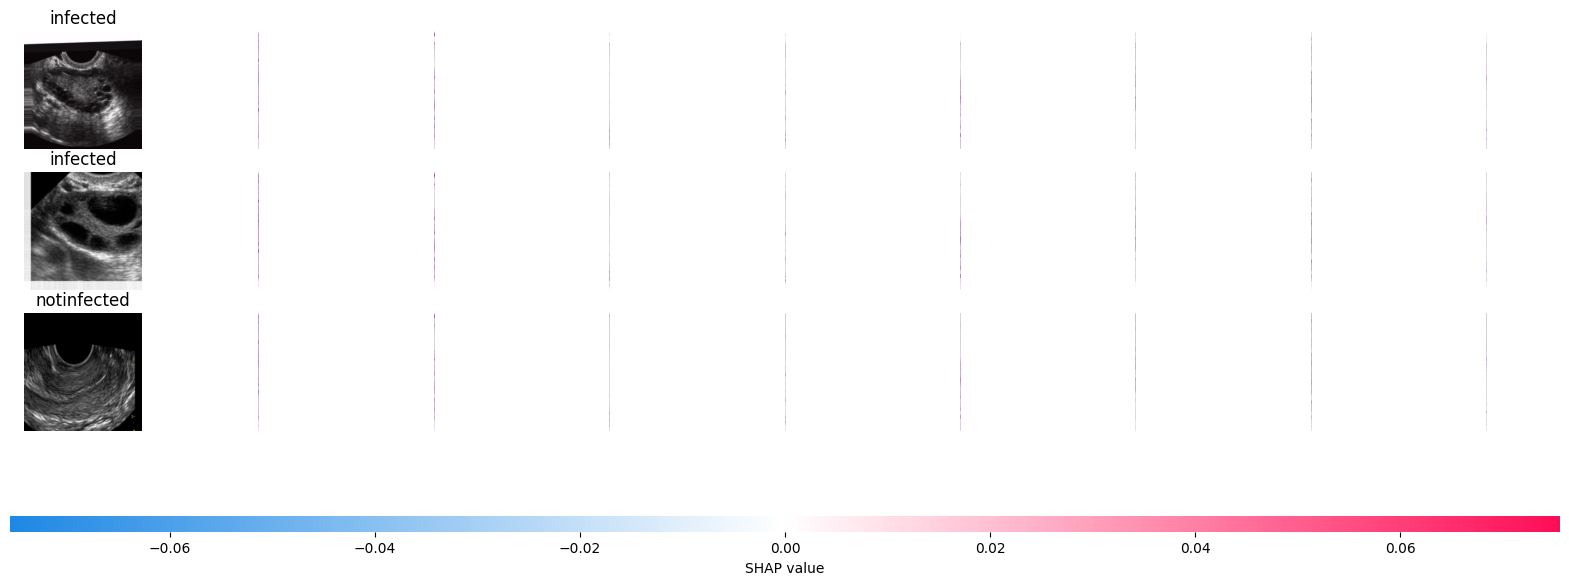

In [28]:
num_samples = shap_numpy[0].shape[0]
shap.image_plot(shap_numpy, test_numpy[:num_samples], true_labels=GT_labels[:num_samples])


IndexError: index 3 is out of bounds for axis 0 with size 3

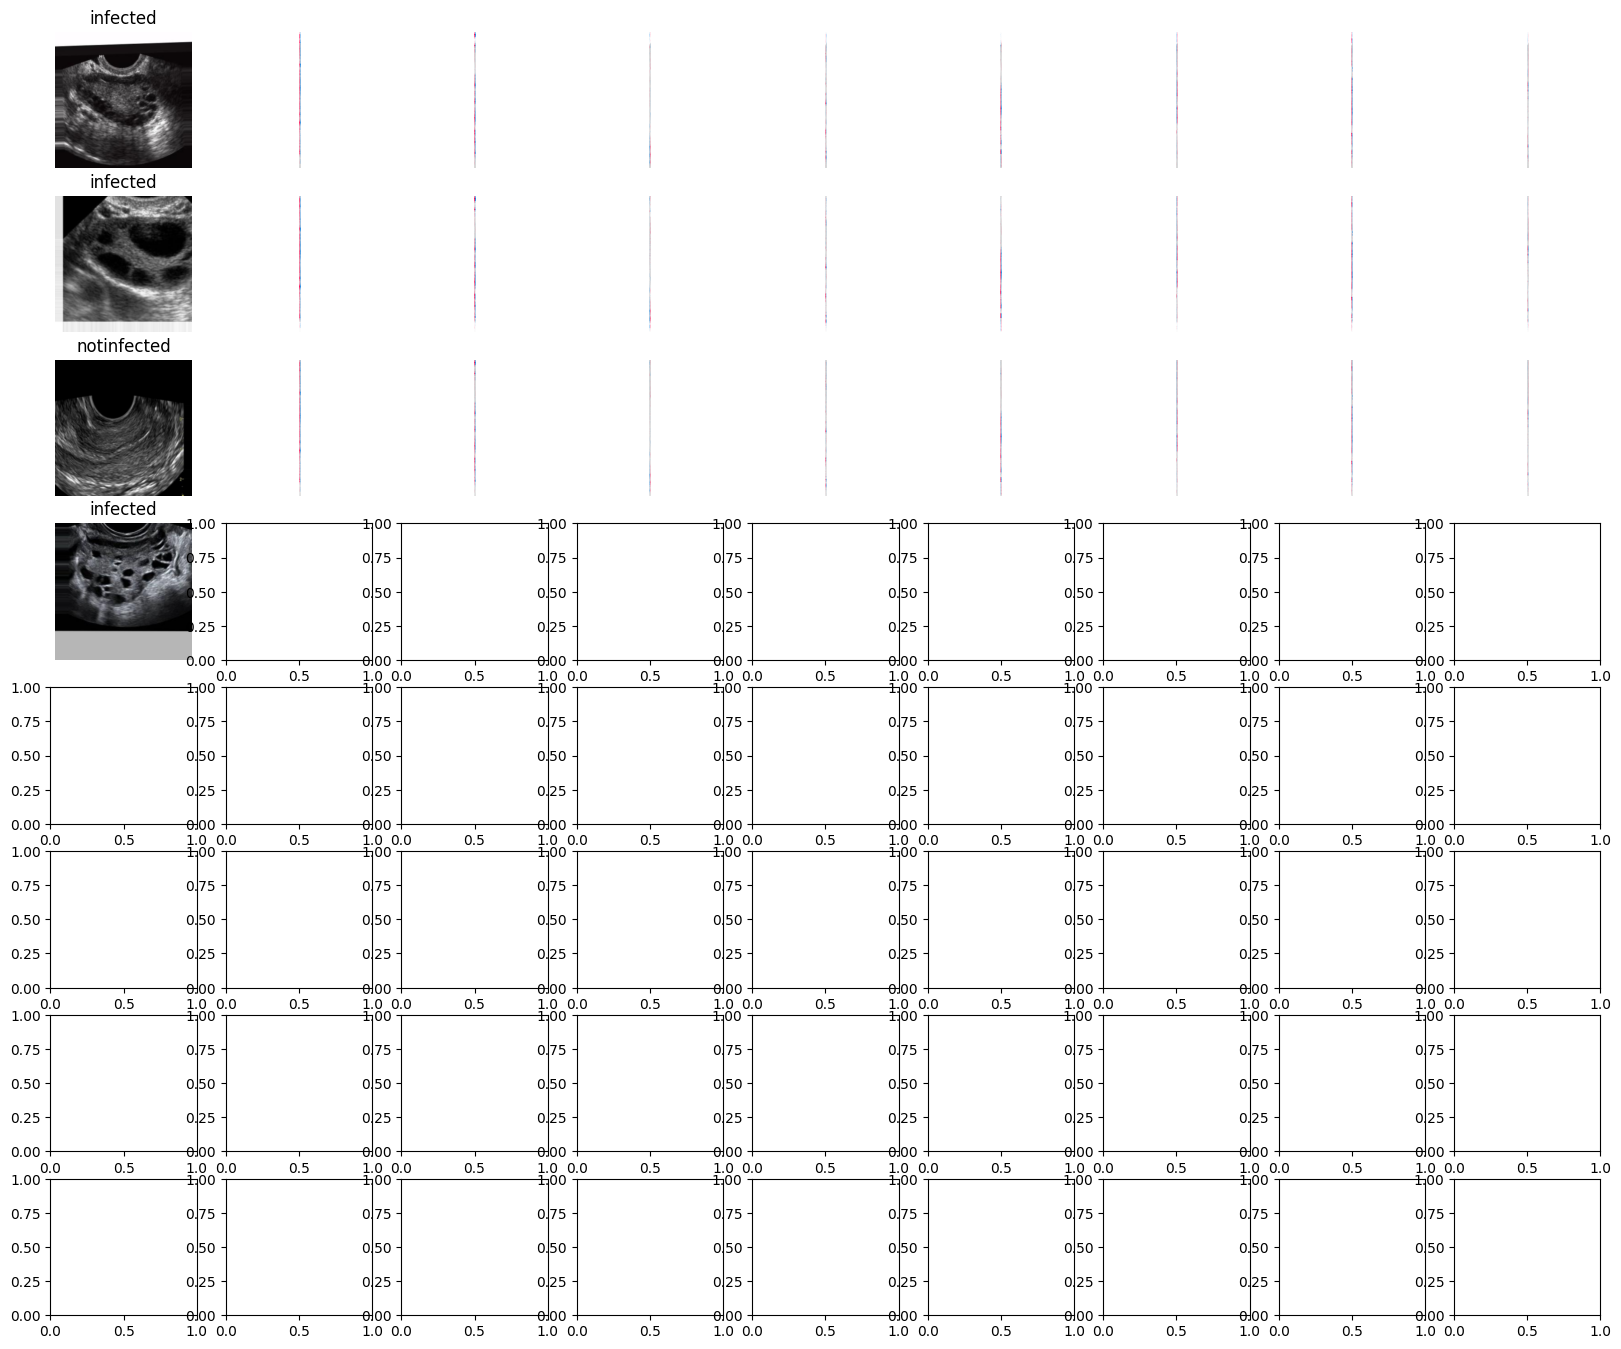

In [29]:
# shap.image_plot(shap_numpy, test_numpy, labels=dataset.classes, true_labels=GT_labels)
shap.image_plot(shap_numpy, test_numpy, true_labels=GT_labels)